In [1]:
#suppress deprecation warnings  
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd 
import matplotlib.pyplot as plt 
import hddm 
from patsy import dmatrix 
import numpy as np
# print(hddm.__version__)

%matplotlib inline
plt.rcParams['figure.figsize'] = 30, 10

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Pre-processing

In [2]:
!pwd
write_dir = '/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/hddm_reg_models/'
print(write_dir)

/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/analysis_nbs
/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/hddm_reg_models/


In [3]:
all_data = hddm.load_csv('/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/combined_learning_sig_obs_data.csv')  

In [4]:
all_data.head(3)

,choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition,B,cpp
0,1.0,0.0,0.0,0.0,599.0,0.711570,2.385458,0.670199,0.0,0.0,112.0,761,hc,0.00000,0.021840
1,1.0,0.0,0.0,0.0,598.0,0.681410,1.939019,0.259707,0.0,1.0,111.0,761,hc,0.00000,0.019044
2,0.0,1.0,0.0,2.0,599.0,0.767118,2.498060,0.740615,0.0,0.0,111.0,761,hc,-0.03276,0.018022


In [5]:
data = all_data[['accuracy', 'rt', 'condition', 'ID', 'B', 'cpp']] 
data = data.rename(index=str, columns={"accuracy": "response", "ID": "subj_idx"})

In [6]:
data.columns = data.columns.str.strip()
data.head()

,response,rt,condition,subj_idx,B,cpp
0,0.0,0.711570,hc,761,0.000000,0.021840
1,0.0,0.681410,hc,761,0.000000,0.019044
2,1.0,0.767118,hc,761,-0.032760,0.018022
3,0.0,0.507209,hc,761,0.007296,0.017503
4,1.0,0.656259,hc,761,0.039621,0.017197


In [7]:
# rtSig = data.rt.std()
# rtMu = data.rt.mean()
# cutoff =  rtMu - rtSig
# data = data[data.rt>cutoff]
# data.reset_index(drop=True, inplace=True)

In [8]:
np.sum(np.isnan(data.cpp))
np.sum(np.isnan(data.rt))
np.sum(np.isnan(data.response))

0

In [9]:
len(data.cpp), len(data.response), len(data.rt)

(48000, 48000, 48000)

In [10]:
data = hddm.utils.flip_errors(data)

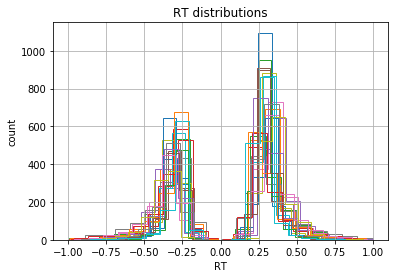

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

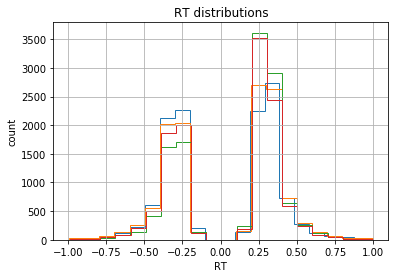

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('condition'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [13]:
np.unique(data.subj_idx), np.unique(data.condition), len(np.unique(data.subj_idx))

(array([761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773,
        775, 776, 777, 778, 779, 780, 781]),
 array(['hc', 'hv', 'lc', 'lv'], dtype=object),
 20)

## Within-subjects regression 

#### Treatment specifies intercept (comparison condition) 
##### (here I'm estimating each predictor coefficient independently, without reference to a comparison condition)
#### C(x) specifies categorical predictor 

##### (design matrix will auto-code dummy variables)

#### trialwise response ~covariate:c(categorical predictor)

In [14]:
a_formula="1+cpp:C(condition)"
v_formula = "1+B:C(condition)"
n_samples, n_burned_samples = 3000, 500
#not running these yet, will take time. 
#formulas are redundant, but named separately for conceptual clarity 
#could maybe also compare fits to categorical predictor alone 

# counter_a_formula = "0+B:C(stim)"
# counter_v_formula = "0+cpp:C(stim)"

# cpp_both_formula = "0+cpp:C(stim)"
# B_both_formula = "0+B:C(stim)"

d_mat_a = dmatrix(a_formula, data)
d_mat_v = dmatrix(v_formula, data)

print(d_mat_a.design_info.column_names, d_mat_v.design_info.column_names)

['Intercept', 'cpp:C(condition)[hc]', 'cpp:C(condition)[hv]', 'cpp:C(condition)[lc]', 'cpp:C(condition)[lv]'] ['Intercept', 'B:C(condition)[hc]', 'B:C(condition)[hv]', 'B:C(condition)[lc]', 'B:C(condition)[lv]']


In [15]:
level1b = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2b = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
level3b = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}
data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
                                                'level2': level2b,
                                                'level3': level3b},
                                                size=10,
                                                subjs=10)

In [16]:
test = hddm.HDDMRegressor(data, 'a~C(condition)', informative=True)
test.sample(100,burn=20)

Adding these covariates:
['a_Intercept', 'a_C(condition)[T.hv]', 'a_C(condition)[T.lc]', 'a_C(condition)[T.lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-                 4%                  ] 4 of 100 complete in 7.9 secHalting at iteration  3  of  100
Could not generate output statistics for v_subj.771
Could not generate output statistics for a_Intercept_subj.765
Could not generate output statistics for v_subj.780
Could not generate output statistics for a_Intercept_subj.780
Could not generate output statistics for v_subj.766
Could not generate output statistics for t_std
Could not generate output statistics for a_Intercept_subj.767
Could not generate output statistics for t_subj.763
Could not generate output statistics for t_subj.771
Could not generate output statistics for a_Intercept_std
Could not generate output statistics for t_subj.776
Could not generate output statistics for v_subj.779
Could not generate output statistics for t_subj.765
Could not generate output statistics for a_Intercept
Could not generate output statistics for v_subj.767
Could not generate output statistics for a_Intercept_subj.766
Could not generate outpu

TypeError: 'NoneType' object is not subscriptable

In [ ]:
test = hddm.HDDMRegressor(data, 'a~BOLD:C(condition)', informative=True)
test.sample(100,burn=20)

In [ ]:
data_b

In [ ]:
d_mat_a, d_mat_v

In [ ]:
v_reg_model = "v ~ "+ v_formula 
a_reg_model = "a ~ "+ a_formula
av_reg_model = [v_reg_model, a_reg_model]
include = ['z']

In [ ]:
data.columns, av_reg_model

In [ ]:
v_within_subj_obs_reg = hddm.HDDMRegressor(data, v_reg_model,bias=True, include=include, informative=True)
v_within_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_traces_obs_cleaned_reg.db', db='pickle')

In [ ]:
v_within_subj_obs_reg.print_stats()

In [ ]:
v_within_subj_obs_reg.print_stats()

In [ ]:
a_within_subj_obs_reg = hddm.HDDMRegressor(data, a_reg_model,bias=True, include=include, informative=True)
a_within_subj_obs_reg.sample(10,burn=4,dbname='a_traces_obs_cleaned_reg.db', db='pickle')

In [ ]:
av_within_subj_obs_reg = hddm.HDDMRegressor(data, av_reg_model,bias=True, include=include, informative=True)
av_within_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='av_traces_obs_cleaned_reg.db', db='pickle')

In [ ]:
aRegressors = ['a_Intercept', "a_cpp:C(stim)[hc]", 
               "a_cpp:C(stim)[lc]", "a_cpp:C(stim)[hv]","a_cpp:C(stim)[lv]"]
vRegressors = ['v_Intercept', "v_B:C(stim)[hc]", "v_B:C(stim)[lc]",
               "v_B:C(stim)[hv]", "v_B:C(stim)[lv]"]
regressors = [aRegressors, vRegressors]
pdists = []; lvls = ['hc', 'lc', 'hv', 'lv']; params = ['a', 'v']
for param, paramRegs in zip(params, regressors):
    traces = av_within_subj_obs_reg.nodes_db.ix[paramRegs, 'node']
    c0 = traces[0].trace().mean()
    condTraces = traces[1:]
    pdist = pd.DataFrame({lvl:cTrace.trace() for (lvl, cTrace) in zip(lvls, condTraces)})
    pdistTidy = pd.melt(pdist, var_name='level')
    pdistTidy['param'] = param
    pdists.append(pdistTidy)
pdists = pd.concat(pdists)
vdists = pdists[pdists.param=='v']
adists = pdists[pdists.param=='a']

In [ ]:
av_within_subj_obs_reg.print_stats()

In [ ]:
t = av_within_subj_obs_reg.nodes_db.ix[['t'], 'mean'][0]
# z = av_within_subj_obs_reg.nodes_db.ix[['z'], 'mean'][0]

v0 = av_within_subj_obs_reg.nodes_db.ix[['v_Intercept'], 'mean'][0]
v_beta_hc = av_within_subj_obs_reg.nodes_db.ix[['v_B:C(stim)[hc]'], 'mean'][0]
v_beta_lc = av_within_subj_obs_reg.nodes_db.ix[['v_B:C(stim)[lc]'], 'mean'][0]
v_beta_hv = av_within_subj_obs_reg.nodes_db.ix[['v_B:C(stim)[hv]'], 'mean'][0]
v_beta_lv = av_within_subj_obs_reg.nodes_db.ix[['v_B:C(stim)[lv]'], 'mean'][0]


In [ ]:
a0 = av_within_subj_obs_reg.nodes_db.ix[['a_Intercept'], 'mean'][0]
a_beta_hc = av_within_subj_obs_reg.nodes_db.ix[['a_cpp:C(stim)[hc]'], 'mean'][0]
a_beta_lc = av_within_subj_obs_reg.nodes_db.ix[['a_cpp:C(stim)[lc]'], 'mean'][0]
a_beta_hv = av_within_subj_obs_reg.nodes_db.ix[['a_cpp:C(stim)[hv]'], 'mean'][0]
a_beta_lv = av_within_subj_obs_reg.nodes_db.ix[['a_cpp:C(stim)[lv]'], 'mean'][0]




In [ ]:
print(a0,a_beta_hc, a_beta_lc)

In [ ]:
plt.plot(v_hc_trials); plt.show()


In [ ]:
v_hc_trials = v0 + v_beta_hc * data[data.stim=='hc']['B'] 
v_lc_trials = v0 + v_beta_lc * data[data.stim=='lc']['B'] 
v_hv_trials = v0 + v_beta_hc * data[data.stim=='hv']['B'] 
v_lv_trials = v0 + v_beta_lc * data[data.stim=='lv']['B'] 


plt.plot(v_hc_trials[:50].values, label='hc')
plt.plot(v_lc_trials[:50].values, label='lc')
plt.plot(v_hv_trials[:50].values, label='hv')
plt.plot(v_lv_trials[:50].values, label='lv')

ax = plt.gca()
ax.set_ylabel('Drift-Rate')
ax.set_xlabel('Trials')
ax.legend()

In [ ]:
v_hc_trials

In [ ]:
a_hc_trials = a0 + a_beta_hc * data[data.stim=='hc']['cpp'] 
a_lc_trials = a0 + a_beta_lc * data[data.stim=='lc']['cpp'] 
a_hv_trials = a0 + a_beta_hc * data[data.stim=='hv']['cpp'] 
a_lv_trials = a0 + a_beta_lc * data[data.stim=='lv']['cpp'] 


plt.plot(a_hc_trials[:50].values, label='hc')
plt.plot(a_lc_trials[:50].values, label='lc')
plt.plot(a_hv_trials[:50].values, label='hv')
plt.plot(a_lv_trials[:50].values, label='lv')

ax = plt.gca()
ax.set_ylabel('Threshold')
ax.set_xlabel('Trials')
ax.legend()

In [ ]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
                             
sns.violinplot(x='level', y='value', data=vdists, palette='viridis', order=lvls, ax=ax1, linewidth=0)
sns.violinplot(x='level', y='value', data=adists, palette='viridis', order=lvls, ax=ax2, linewidth=0)
ax1.set_ylabel('Posterior Density')
ax2.set_ylabel('')
ax1.set_title('Drift-Rate ($v$)')
ax2.set_title('Boundary Height ($a$)')

plt.tight_layout()
sns.despine()

#### save models

In [ ]:
av_within_subj_obs_reg.save(write_dir+'av_within_subj_observed_cleaned_reg')
a_within_subj_obs_reg.save(write_dir+'a_within_subj_observed_cleaned_reg')
v_within_subj_obs_reg.save(write_dir+'v_within_subj_observed_cleaned_reg')

#### extract DIC score

In [ ]:
v_within_subj_obs_reg.dic, a_within_subj_obs_reg.dic, av_within_subj_obs_reg.dic

In [ ]:
v_within_subj_obs_reg.dic

#### plot within-subjects effects for winning model

In [ ]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

# names = [r'$a+v$',r'$v$',r'$a$']
# colors = ['red', 'green', 'blue']
names = ['combined', 'drift rate', 'decision threshold']
dics = [av_within_subj_obs_reg.dic, v_within_subj_obs_reg.dic, a_within_subj_obs_reg.dic]
bars=plt.barh(names, dics, color='forestgreen')
plt.xlim([-7825,-7700])

plt.xlabel('DIC score')
bars[0].set_alpha(1)
bars[1].set_alpha(.8)
bars[2].set_alpha(.5)
plt.axvline(av_within_subj_obs_reg.dic, color='k', alpha=0.5, linestyle = '--')
# plt.savefig(write_dir+'observed_dics.pdf')

In [ ]:
v_hc, v_hv, v_lc, v_lv = av_within_subj_obs.nodes_db.ix[['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]'], 'node']


drift_fig=hddm.analyze.plot_posterior_nodes([v_hc, v_hv, v_lc, v_lv])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('All groups: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

In [ ]:
drift_fig=hddm.analyze.plot_posterior_nodes([v_hc, v_lc])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.legend()
plt.title('All groups: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

In [ ]:
a_hc, a_hv, a_lc, a_lv  = av_within_subj_obs.nodes_db.ix[['a_C(stim)[hc]', 'a_C(stim)[hv]', 'a_C(stim)[lc]', 'a_C(stim)[lv]'], 'node']
bound_fig = hddm.analyze.plot_posterior_nodes([a_hc, a_hv, a_lc, a_lv])
plt.legend()
plt.xlabel('bound')
plt.ylabel('Posteriore probability')
plt.title('All Groups: Group mean posteriors of within-subject bound effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

#### Hypothesized contrasts

In [ ]:
a_hc, a_hv, a_lc, a_lv  = av_within_subj_obs.nodes_db.ix[['a_C(stim)[hc]', 'a_C(stim)[hv]', 'a_C(stim)[lc]', 'a_C(stim)[lv]'], 'node']
hddm.analyze.plot_posterior_nodes([a_lv, a_hv])
plt.xlabel('bound')
plt.ylabel('Posterior probability')
plt.title('Volatility: Group mean posteriors of within-subject bound effects.')

In [ ]:
v_hc, v_hv, v_lc, v_lv = av_within_subj_obs.nodes_db.ix[['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]'], 'node']
hddm.analyze.plot_posterior_nodes([v_hc, v_lc])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Conflict: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

#### all stats

In [ ]:
# v_within_subj.print_stats()

In [ ]:
av_within_subj_obs.plot_posterior_predictive(figsize=(14, 10))

In [ ]:
# tst hyp. that bound ^ with vol
print("P(HV < LV) = ", (a_hv.trace() < a_lv.trace()).mean())
print("P(HC > LC) = ", (v_hc.trace() > v_lc.trace()).mean())

In [ ]:
print("P(LV < LC) = ", (a_lv.trace() < a_lc.trace()).mean())
print("P(LV < HC) = ", (a_lv.trace() < a_hc.trace()).mean())
print("P(LV < HV) = ", (a_lv.trace() < a_hv.trace()).mean())

In [ ]:
# tst hyp. that drift dec. with conf
print("P(HC > LC) = ", (v_hc.trace() > v_lc.trace()).mean())
print("P(HC > LV) = ", (v_hc.trace() > v_lv.trace()).mean())
print("P(HC > HV) = ", (v_hc.trace() > v_hv.trace()).mean())
